# BCI-I & IDUN Tutorial
This notebook is intended to be a tutorial for the BCI-I & IDUN Challenge.
It covers the basics of data loading, preprocessing, and model training.

We start by loading the raw EEG and labels data and visualizing it and the training labels.
For this part of the tutorial we don't use the data organized into epochs from `01_data_preparation.ipynb`. This is intended to demonstrate the content of the original dataset and for anyone wishing to start their analysis with the intact dataset.

Next, we load pre-processed data chunked into epochs around each event. 
Finally, we train a few simple classifiers and a deep learning model.

## Loading raw data
Here we show how to load the raw data and visualize it. 
This is not necessary for the challenge since we already provide data separated into epochs, but can be useful for understanding the data.
You may also wish to apply your own pre-processing steps before creating epochs, check `01_data_preparation.ipynb` for more details. 

We use `torch` for the deep learning model. If you wish to use a different framework, comment out `import torch` and don't run the final part of this notebook.


In [24]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import scipy
import torch

from utils import load_eeg, load_labels, plot_eeg, get_event_epochs, markers


# choose a subject [0-3 only, subject 4 is in the test set!]
subject = 'S003'

In [25]:
# where your data is stored
data_dir = Path(r'')

In [26]:

# load raw EEG data with MNE
eeg = load_eeg(data_dir, subject)


Creating RawArray with float64 data, n_channels=1, n_times=5772730
    Range : 0 ... 5772729 =      0.000 ... 23090.916 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>


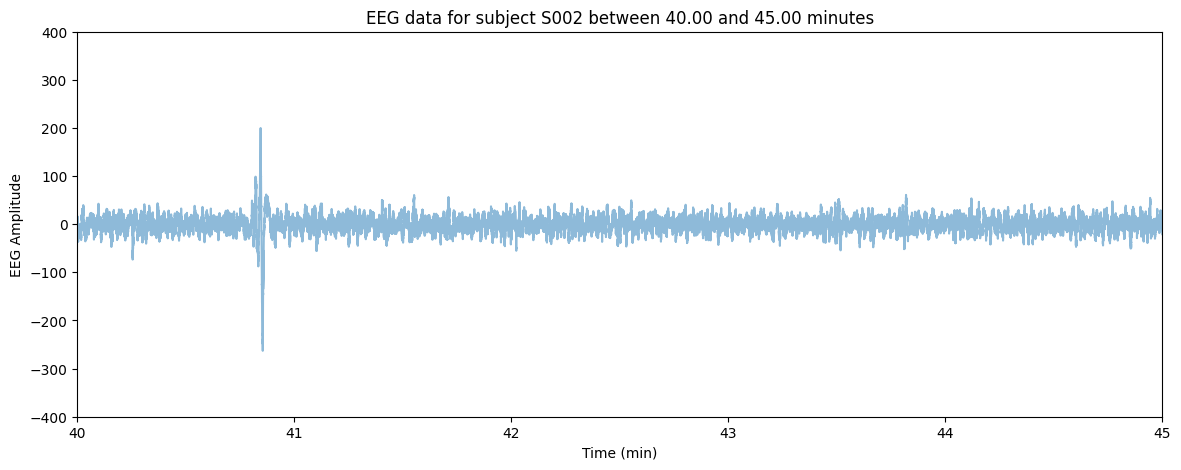

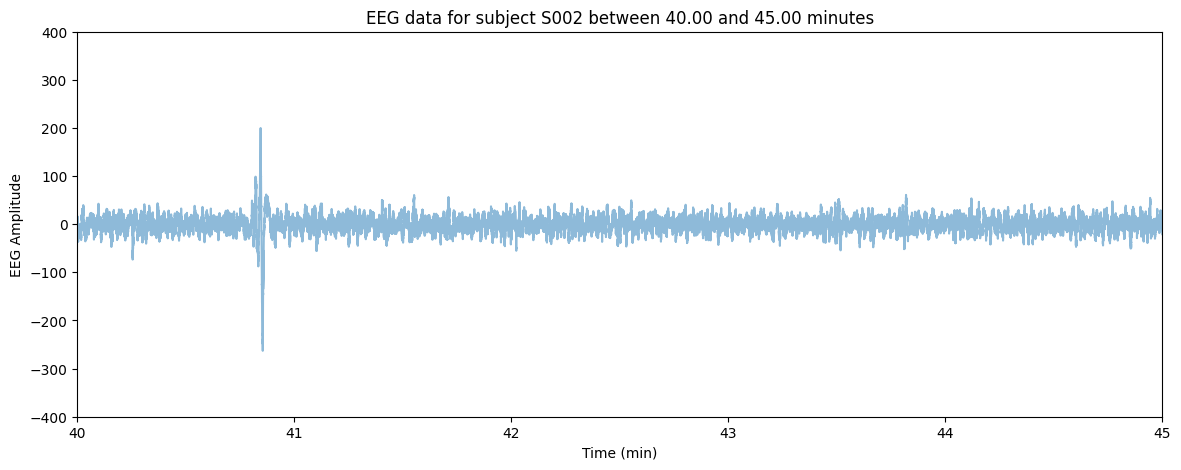

In [27]:
# this function plots the EEG data. You can pass a start/end time in minutes to zoom in on a particular time window
plot_eeg(eeg, 'S002', 40, 45)[0]



#### Loading labels
Labels are stored in a separate CSV file which we load as a pandas DataFrame.


In [28]:
labels = load_labels(data_dir, subject)
labels = labels[labels.Marker.isin(markers)]
print(labels.head())


  Marker  Timestamp_samples  Epoch
0    REM             109060     15
1    REM             110044     15
2    REM             111026     15
3    REM             112076     15
4    REM             113199     16


Labels are not balanced: there's more of some event markers than others. This is very important for training and evaluating models, so we should pay particular attention to this.

In [29]:
print("\nCounts of each marker:")
print(labels.Marker.value_counts())



Counts of each marker:
K                             378
REM                           257
GS                            218
S                             123
Son                            30
A                              20
Soff                           14
BAD_QUALITY_GUARDIAN_START      4
BAD_QUALITY_GUARDIAN_END        4
MS                              2
Name: Marker, dtype: int64


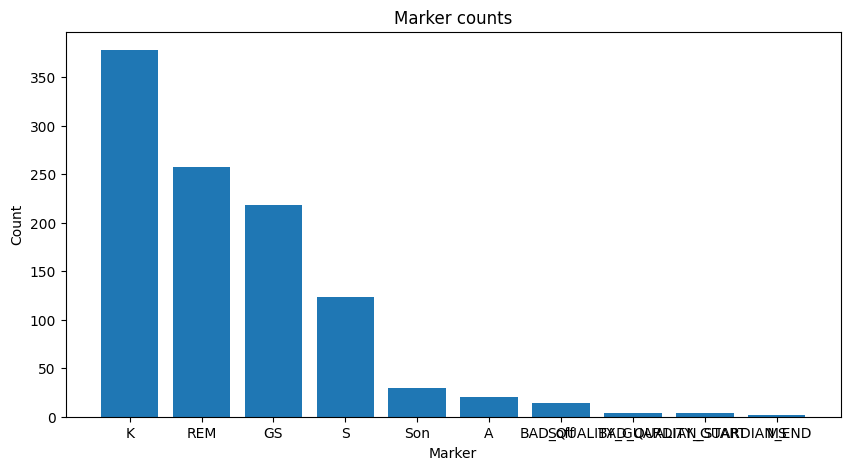

In [30]:

f, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels.Marker.value_counts().index, labels.Marker.value_counts().values)
ax.set(title="Marker counts", xlabel="Marker", ylabel="Count")
plt.show()


Later, when we train models we will see the effect of this inbalance. For now, we can overlay the labels timestamps over the EEG data to get an idea of the timing of each event and what the signal looks like around each event.

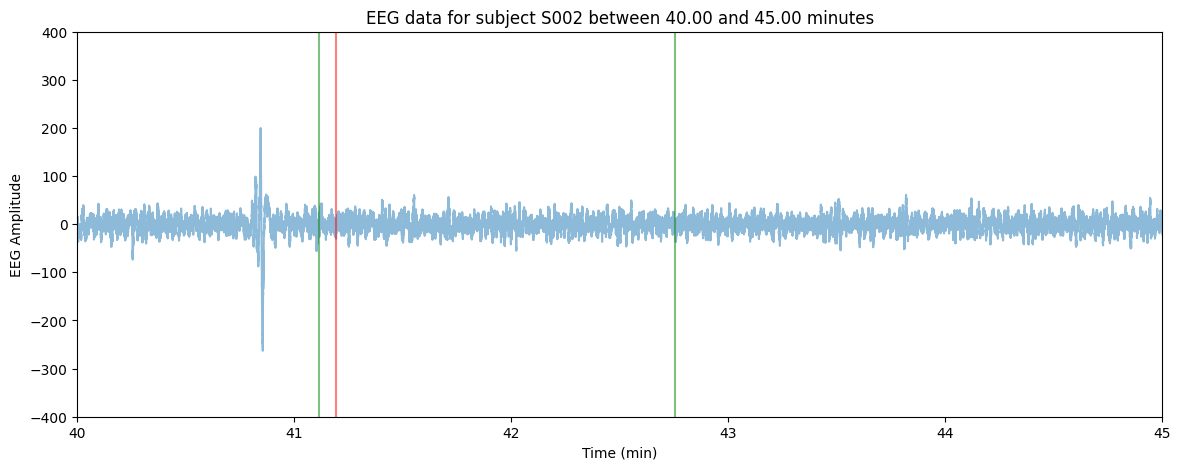

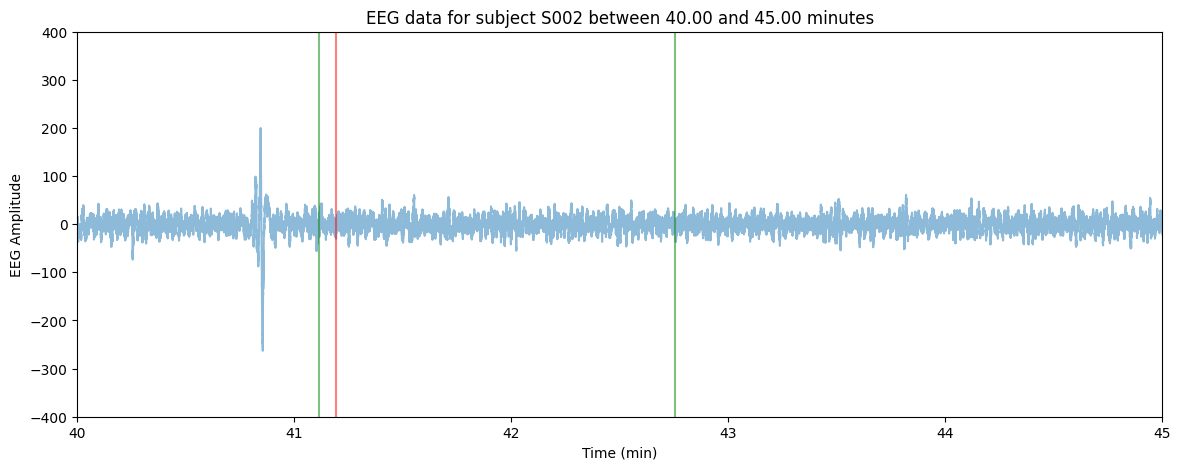

In [31]:

plot_eeg(eeg, subject, 30, 50, labels)[0]

Finally, we can create "epochs" around each event and then collect all epochs for a particular event to get an idea for what the EEG signal looks like on avarage around each event. Note that epochs are taken to be 30 seconds long and starting at the event onset. You can play around with the `tmin` and `tmax` parameters to see how the epochs change for the function below to see how the epochs change, but keep in mind that pre-processed data and **evaluation data** assume this length and onset.


Not setting metadata
257 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 257 events and 7501 original time points ...
1 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated


c:\Users\feder\Documents\github\BCII-IDUN-CHallenge\utils.py:65: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events=events, tmin=tmin, tmax=tmax, baseline=None, preload=True)


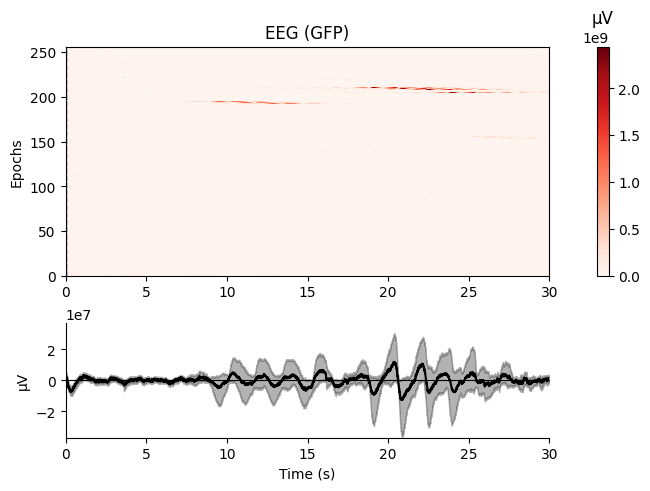

[<Figure size 640x480 with 3 Axes>]

In [32]:
epochs = get_event_epochs(eeg, labels, 'REM')
epochs.plot_image()


## Loading pre-processed data

`_X.npy` and `_Y.npy` files contain the pre-processed data and labels, respectively.
When loaded, they should be arrays of shape `n_epochs x n_samples` and `n_epochs` respectively.
`n_samples` is `7501` (30 seconds of EEG at 250 Hz).The number of epochs changes across subjects, but the number of samples per epoch is fixed.


In [33]:
data_dir = Path(r'F:\Dropbox (Personal)\BCII\BCI Challenges\202411_IDUN_kaggle_challenge\HACKATHON_Dec2023\processed')


X = np.load(data_dir / f"{subject}_X.npy")
Y = np.load(data_dir / f"{subject}_Y.npy")

print(X.shape, Y.shape)


(823, 7501) (823,)


The `Y` array contains the marker label associated with each epoch.

In [34]:
Y[:5]

array(['S', 'S', 'S', 'S', 'S'], dtype='<U4')

To get the epochs associated to a particular event, we can simply index the `Y` array. The following plot should look similar to the one above.


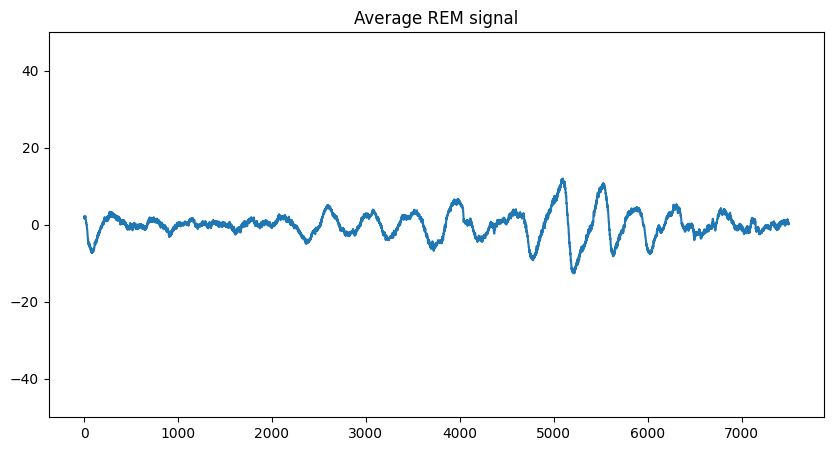

In [35]:
idxs = np.where(Y == 'REM')[0]
rem_X = X[idxs]

rem_average = rem_X.mean(axis=0)

f, ax = plt.subplots(figsize=(10, 5))
ax.plot(rem_average)
ax.set(title="Average REM signal", ylim=[-50, 50])
plt.show()


As we can see, the number of epochs per event is different across events.

In [36]:

counts = {m: len(np.where(Y == m)[0]) for m in markers}
percents = {m: round(counts[m]/len(Y) * 100, 2) for m in markers}
summary = pd.DataFrame({'Count': counts, 'Percent': percents})
summary




,Count,Percent
S,123,14.95
K,378,45.93
REM,256,31.11
Son,30,3.65
Soff,14,1.70
A,20,2.43
MS,2,0.24


## Fitting models
In this section we show how to fit a few simple models using `scikit-learn` and a more advanced deep learning model (time-series convolutional neural network) with `PyTorch`.

For simplicity, we will split the data from one subject into training and test sets. 
For the competition, however, you will have access to all the training data from three subjects and you will be asked to make predictions on data from a fourth subject for whom you do not have labels.

The code implementation will be similar, however, so you can use these examples to get started.


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import balanced_accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

### Train/test split
We need to "stratify" the split to ensure that the training and test sets have the same proportions of each event type as the whole dataset.


In [38]:
def print_class_proportions(Y, label:str):
    counts = {m: len(np.where(Y == m)[0]) for m in markers}
    percents = {m: round(counts[m]/len(Y) * 100, 2) for m in markers}
    summary = pd.DataFrame({'Count': counts, 'Percent': percents})
    # sort by count
    summary = summary.sort_values(by='Count', ascending=False)
    print(f"\n{label} dataset:")
    print(summary)


# counts for the whole dataset
print_class_proportions(Y, "Whole dataset")



Whole dataset dataset:
      Count  Percent
K       378    45.93
REM     256    31.11
S       123    14.95
Son      30     3.65
A        20     2.43
Soff     14     1.70
MS        2     0.24


Example split without stratification.

In [39]:
# splitting the data without stratification
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print_class_proportions(Y_train, "Training set")
print_class_proportions(Y_test, "Test set")




Training set dataset:
      Count  Percent
K       303    46.05
REM     200    30.40
S       104    15.81
Son      22     3.34
A        16     2.43
Soff     12     1.82
MS        1     0.15

Test set dataset:
      Count  Percent
K        75    45.45
REM      56    33.94
S        19    11.52
Son       8     4.85
A         4     2.42
Soff      2     1.21
MS        1     0.61


If you repeat the step above a few times, you will see that the proportions of each event type are different in the training and test sets. This is particularly bad for rare events, since the test data may have very few of them and even small changes in their distribution across trianing and test data can skew the results. For example, imagine if all markers for a rare event end up in the test set, your model would never see it during training!


In [40]:
# the classess are not balanced, so we need to stratify the split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
print_class_proportions(Y_train, "Training set")
print_class_proportions(Y_test, "Test set")



Training set dataset:
      Count  Percent
K       302    45.90
REM     205    31.16
S        98    14.89
Son      24     3.65
A        16     2.43
Soff     11     1.67
MS        2     0.30

Test set dataset:
      Count  Percent
K        76    46.06
REM      51    30.91
S        25    15.15
Son       6     3.64
A         4     2.42
Soff      3     1.82
MS        0     0.00


You should see much better results with the stratified splits. Our final pre-processing step is to standardize the EEG data.

In [41]:
# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fitting models.
We define a couple of helper functions to fit models and plot the confusion matrix.

Our main metric will be balanced `F1` score which is ideal for imbalanced datasets, striking a balance between precision and recall. We also show `balanced_accuracy_score`. 
We also plot the confusion matrix to see how often each event type is predicted as another.


In [42]:
def plot_confusion_matrix(conf_mat, markers, title):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=markers, yticklabels=markers, ax=ax)

    # highlight the diagonal elements
    for i in range(conf_mat.shape[0]):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=1))

    ax.set(
           title=title,
           xlabel='Predicted',
           ylabel='True',
           aspect='equal'
           )
    plt.show()


def fit_and_eval_sk_classifier(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)

    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)

    if set(Y_pred_train) != set(Y_train):
        print(f"Predicted classes {set(Y_pred_train)} do not match true classes {set(Y_train)}")
    if set(Y_pred_test) != set(Y_test):
        print(f"Predicted classes {set(Y_pred_test)} do not match true classes {set(Y_test)}")

    train_acc = balanced_accuracy_score(Y_train, Y_pred_train)
    test_acc = balanced_accuracy_score(Y_test, Y_pred_test)
    print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

    train_f1 = f1_score(Y_train, Y_pred_train, average='weighted')
    test_f1 = f1_score(Y_test, Y_pred_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
    
    conf_mat = confusion_matrix(Y_test, Y_pred_test, normalize='true')
    title=f"{clf.__class__.__name__} - Train: {train_f1:.4f}, Test: {test_f1:.4f}"
    plot_confusion_matrix(conf_mat, markers, title)


Our first model is a `multi-class logistic regression`. Logistic regression is a simple model that is often used as a baseline. They are binary classifiers, but scikit-learn allows us to fit multi-class models by fitting multiple OvR (one-vs-rest) classifiers.


Predicted classes {'K', 'REM', 'S'} do not match true classes {'A', 'Soff', 'S', 'REM', 'K', 'Son'}
Train accuracy: 1.0000, Test accuracy: 0.1678
Train F1: 1.0000, Test F1: 0.3328


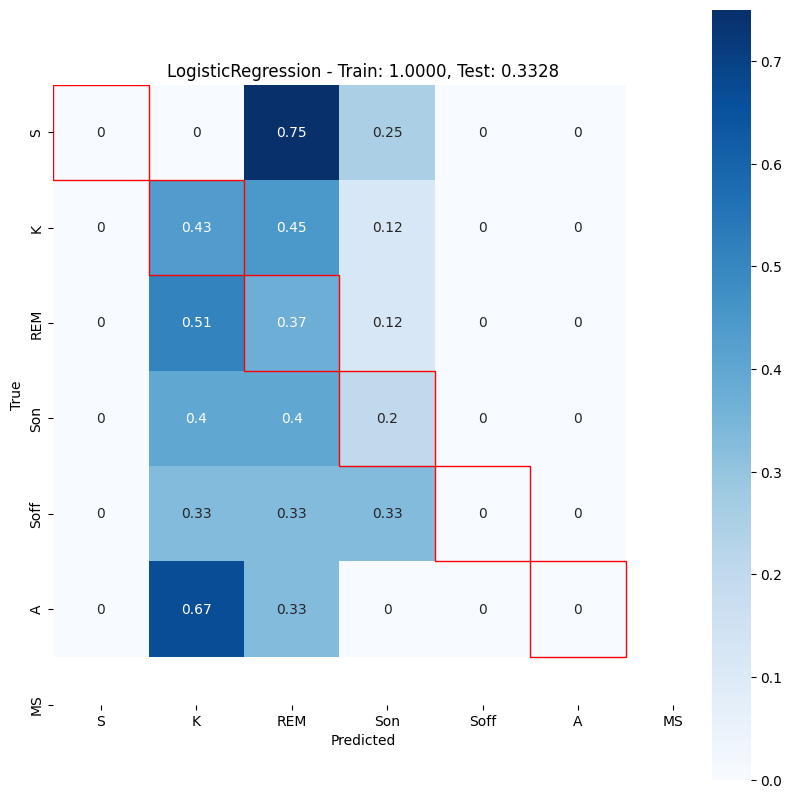

In [43]:
# fit multi-class logistic regression
clf = LogisticRegression(multi_class='ovr', random_state=42, max_iter=1000, class_weight=None)
fit_and_eval_sk_classifier(clf, X_train, Y_train, X_test, Y_test)


It seems to be predicting most data as `K` or `REM`. This is not surprising given that these are the most frequent event types.


In [44]:
print_class_proportions(Y, "Whole dataset")


Whole dataset dataset:
      Count  Percent
K       378    45.93
REM     256    31.11
S       123    14.95
Son      30     3.65
A        20     2.43
Soff     14     1.70
MS        2     0.24


We can use `class_weight="balanced"` to give more weight to less frequent classes. This should improve the performance of the model on the minority classes.


Predicted classes {'S', 'REM', 'MS', 'K', 'Son'} do not match true classes {'A', 'Soff', 'S', 'REM', 'K', 'Son'}
Train accuracy: 1.0000, Test accuracy: 0.1590
Train F1: 1.0000, Test F1: 0.3150


C:\Users\feder\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


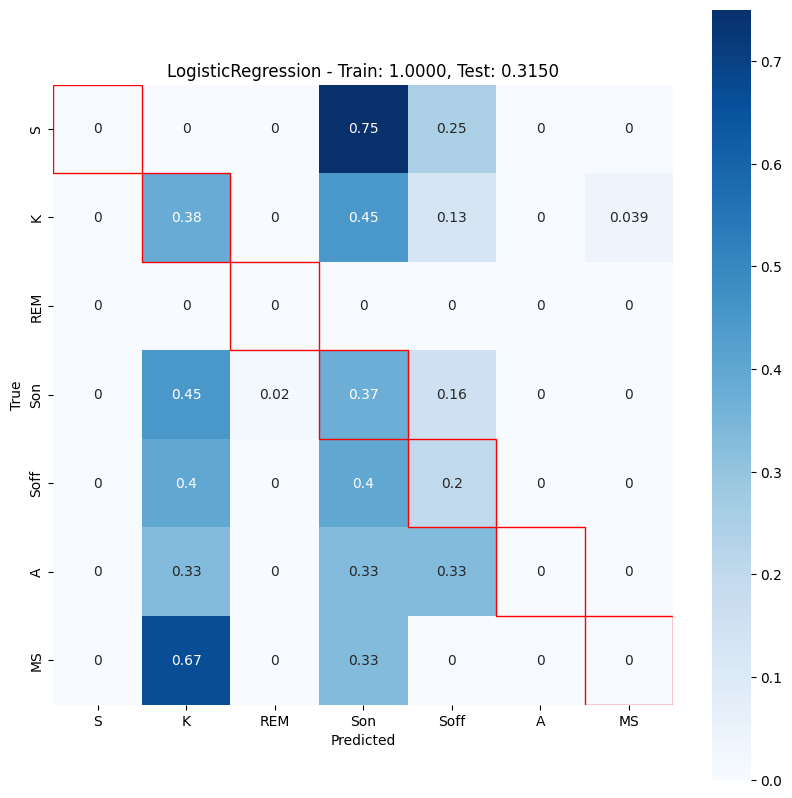

In [45]:
# fit multi-class logistic regression with class weights
clf = LogisticRegression(multi_class='ovr', random_state=42, max_iter=1000, class_weight="balanced")    
fit_and_eval_sk_classifier(clf, X_train, Y_train, X_test, Y_test)


This didn't improve too much, but maybe that's because logistic regression is just too simple of a model for this task. 
Let's try a couple more advanced models (SVM and random forest). Play around with `class_weight` to see how it affects the results.


Train accuracy: 0.7127, Test accuracy: 0.1737
Train F1: 0.3239, Test F1: 0.1740


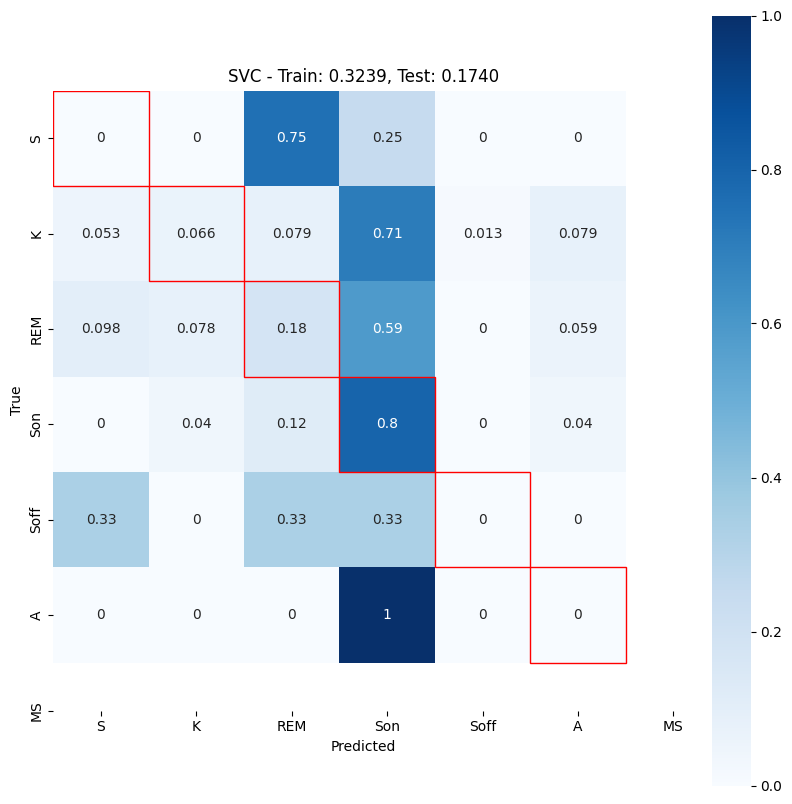

In [46]:
from sklearn.svm import SVC

svc_cls = SVC(kernel='rbf', random_state=42, class_weight="balanced")  # class_weight None or "balanced"
fit_and_eval_sk_classifier(svc_cls, X_train, Y_train, X_test, Y_test)

You can also define your own custom weights based on the class frequencies.
The example below is a **bad** set of weights, but you can play around with weights to see how to get the right balance across classes.

Predicted classes {'A', 'Soff', 'S', 'REM', 'K', 'Son'} do not match true classes {'A', 'Soff', 'S', 'REM', 'MS', 'K', 'Son'}
Predicted classes {'K', 'REM'} do not match true classes {'A', 'Soff', 'S', 'REM', 'K', 'Son'}
Train accuracy: 0.3005, Test accuracy: 0.1711
Train F1: 0.2594, Test F1: 0.2006


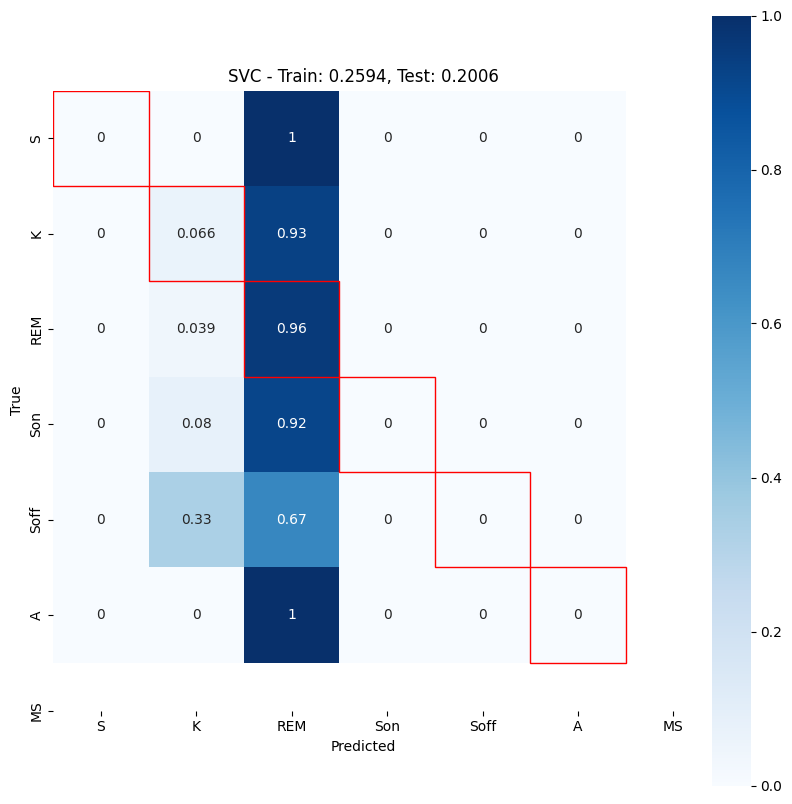

In [47]:
weights = {
    'S' : 1,
    'A': 1,
    'K': 1,
    'MS': 1,
    'REM': 10,
    'Son': 1,
    'Soff': 1,
}

svc_cls = SVC(kernel='rbf', random_state=42, class_weight=weights)  # pass  your own weights dictionary
fit_and_eval_sk_classifier(svc_cls, X_train, Y_train, X_test, Y_test)


Let's try Random Forest next.


Predicted classes {'A', 'K', 'REM', 'S'} do not match true classes {'A', 'Soff', 'S', 'REM', 'K', 'Son'}
Train accuracy: 0.8349, Test accuracy: 0.1391
Train F1: 0.9261, Test F1: 0.2991


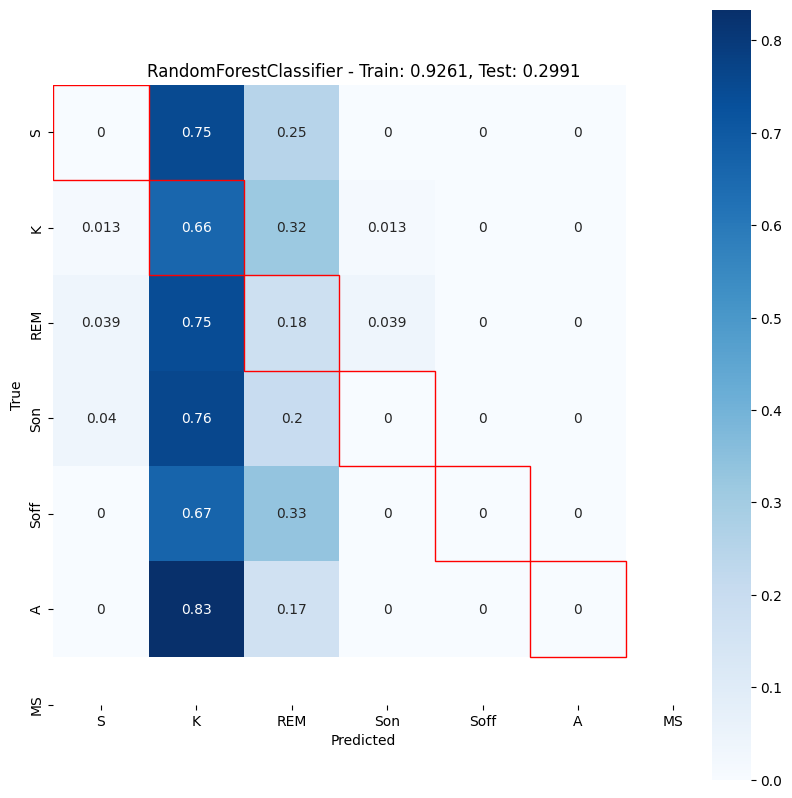

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf_cls = RandomForestClassifier(n_estimators=5, random_state=42, class_weight="balanced")
fit_and_eval_sk_classifier(rf_cls, X_train, Y_train, X_test, Y_test)


All of this model showed different levels of performance and different kinds of errors.
The simple logistic regression was perhaps just too simple to achieve good performance. On the other hand, the SVM and Random Forest models seem to be overfitting the data, achieving high accuracy on the training set but low accuracy on the test set.
You're free to experiment with pre-processing steps and training approaches to improve the performance of these models.



## A deep learning model

Deep learning models are a natural choice for time-series classification tasks.
We'll define a simple time-series convolutional neural network (tCNN) and train it using PyTorch.

We'll build on the lessons learned from the previous models to improve the performance of the deep learning model. We want something that is powerful enough to learn the complex relationships between EEG signals and the different event types, but we'll be careful to avoid overfitting.
We'll apply three standard techniques to avoid overfitting:
- **Augmentation**: we'll create perturbed versions of the data to make the model more robust.
- **Regularization**: we'll add a penalty to the loss function to discourage complex models.
- **Early stopping**: we'll do a short training run (you might want to use the validation loss to stop training more precisely)


The following block defines the model architecture.


In [49]:
# define a time convolutional feed forward neural network with pytoimport torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch

class TimeSeriesCNN(nn.Module):
    def __init__(self, input_length, num_classes=7):
        super(TimeSeriesCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Calculate the size of flattened features
        self.flatten_size = self._get_flatten_size(input_length)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def _get_flatten_size(self, input_length):
        # Helper function to calculate flattened size
        x = torch.randn(1, 1, input_length)
        x = self.conv_layers(x)
        return x.shape[1] * x.shape[2]
    
    def forward(self, x):
        # x shape: (batch_size, n_samples)
        # Add channel dimension
        x = x.unsqueeze(1)  # (batch_size, 1, n_samples)
        
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

        


Next, we define a training function that will handle the augmentation, regularization, and early stopping for us.


In [50]:

# Training function
def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda', lr=0.001, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights) 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # weight_decay is L2 regularization
        
    model = model.to(device)
    best_val_loss = np.inf
    best_model = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model.state_dict()
        
        val_acc = 100. * correct / total
        
        if epoch == 0 or (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
            print('--------------------')

    return best_model

Finally, we define some custom `Dataset`s to handle the augmentation and data loading.


In [51]:
from torch.utils.data import Dataset

class TimeSeriesAugmentation:
    def __init__(self, noise_level=0.05, shift_range=10):
        self.noise_level = noise_level
        self.shift_range = shift_range
    
    def add_noise(self, x):
        noise = torch.randn_like(x) * self.noise_level
        return x + noise
    
    def time_shift(self, x):
        # Generate random shift value
        shift = torch.randint(-self.shift_range, self.shift_range, (1,)).item()
        # Roll the tensor along the time dimension
        return torch.roll(x, shifts=shift, dims=0)
    
    def scale(self, x):
        scale_factor = torch.rand(1) * 0.4 + 0.8  # Random scale between 0.8 and 1.2
        return x * scale_factor

class AugmentedDataset(Dataset):
    def __init__(self, X, y, augment=True):
        self.X = X
        self.y = y
        self.augment = augment
        self.aug = TimeSeriesAugmentation()
    
    def __getitem__(self, idx):
        x = self.X[idx].clone()  # Create a copy to avoid modifying original data
        if self.augment:
            if torch.rand(1) < 0.5:
                x = self.aug.add_noise(x)
            if torch.rand(1) < 0.5:
                x = self.aug.time_shift(x)
            if torch.rand(1) < 0.5:
                x = self.aug.scale(x)
        return x, self.y[idx]
    
    def __len__(self):
        return len(self.X)

### Training the DL model

We need to convert the labels to integers and then to PyTorch tensors and turn the data into PyTorch tensors.
Then we prepare dataloaders using our custom datasets


In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# convert Y from text labels to integer labels
_markers = list(set(Y))
_Y_train = [_markers.index(m) for m in Y_train]
_Y_test = [_markers.index(m) for m in Y_test]

# Convert to PyTorch tensors
_X_train = torch.FloatTensor(X_train)
_Y_train = torch.LongTensor(_Y_train)
_X_test = torch.FloatTensor(X_test)
_Y_test = torch.LongTensor(_Y_test)

# Create data loaders
train_dataset = AugmentedDataset(_X_train, _Y_train)
val_dataset = AugmentedDataset(_X_test, _Y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


We're finally ready to train the model.


In [53]:

# Initialize model
input_length = X_train.shape[1]  # number of time samples
model = TimeSeriesCNN(input_length=input_length, num_classes=len(set(Y)))

model = model.to(device)

# Train model
best_model = train_model(model, train_loader, val_loader, num_epochs=30, device=device, lr=1e-4)


Epoch [1/30]
Train Loss: 1.5258, Train Acc: 40.43%
Val Loss: 1.4482, Val Acc: 45.45%
--------------------
Epoch [5/30]
Train Loss: 1.1034, Train Acc: 54.26%
Val Loss: 1.3398, Val Acc: 45.45%
--------------------
Epoch [10/30]
Train Loss: 0.8053, Train Acc: 66.87%
Val Loss: 1.3845, Val Acc: 50.30%
--------------------
Epoch [15/30]
Train Loss: 0.5813, Train Acc: 80.55%
Val Loss: 1.8653, Val Acc: 52.73%
--------------------
Epoch [20/30]
Train Loss: 0.3343, Train Acc: 89.51%
Val Loss: 1.8706, Val Acc: 56.36%
--------------------
Epoch [25/30]
Train Loss: 0.2645, Train Acc: 91.79%
Val Loss: 2.5796, Val Acc: 58.18%
--------------------
Epoch [30/30]
Train Loss: 0.1700, Train Acc: 96.05%
Val Loss: 2.9935, Val Acc: 58.18%
--------------------


To **evaluate** the model, we can load the best model and compute the balanced accuracy and F1 score. 
We also plot the confusion matrix to see how often each event type is predicted as another.

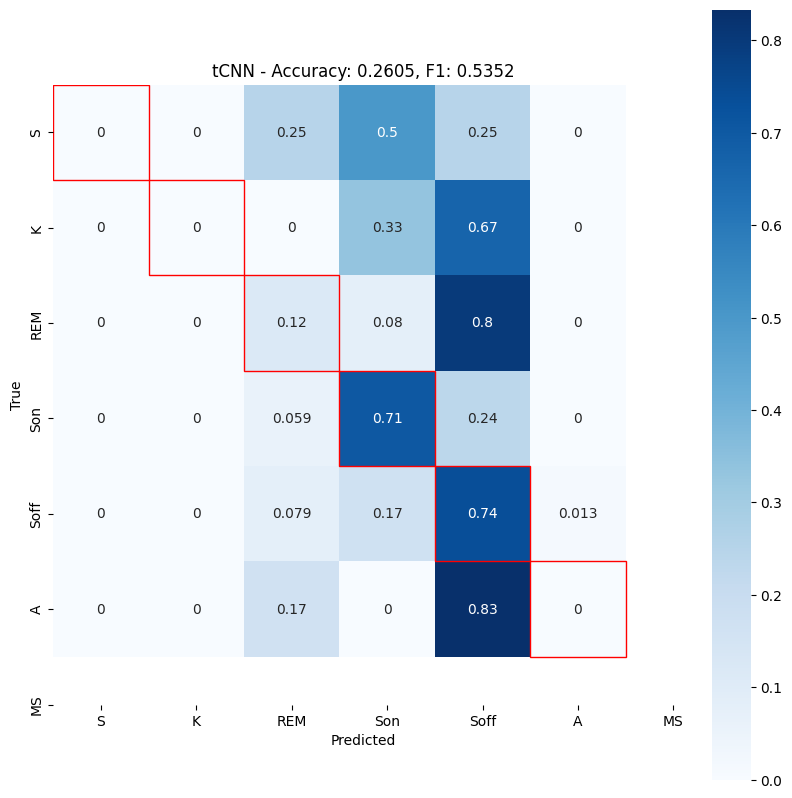

In [54]:
# load best model
model.load_state_dict(best_model)

# compute metric
Y_pred = model(_X_test.to(device)).argmax(1).cpu().numpy()
score = balanced_accuracy_score(_Y_test, Y_pred)
f1 = f1_score(_Y_test, Y_pred, average='weighted')

# plot confusion matrix
conf_mat = confusion_matrix(_Y_test, Y_pred, normalize='true')
plot_confusion_matrix(conf_mat, markers, f"tCNN - Accuracy: {score:.4f}, F1: {f1:.4f}")



Similarly to what we did for the previous models, we can balance the classes by computing the class weights based on the frequency of each class in the training set.
Here we compute the weights of each class in the training set and pass them to the CrossEntropyLoss function.


Epoch [1/30]
Train Loss: 0.2083, Train Acc: 94.07%
Val Loss: 13.9791, Val Acc: 53.94%
--------------------
Epoch [5/30]
Train Loss: 0.2109, Train Acc: 92.10%
Val Loss: 13.9435, Val Acc: 53.33%
--------------------
Epoch [10/30]
Train Loss: 0.1572, Train Acc: 94.07%
Val Loss: 14.1500, Val Acc: 54.55%
--------------------
Epoch [15/30]
Train Loss: 0.1733, Train Acc: 93.31%
Val Loss: 17.0788, Val Acc: 52.12%
--------------------
Epoch [20/30]
Train Loss: 0.1436, Train Acc: 95.90%
Val Loss: 15.5578, Val Acc: 55.76%
--------------------
Epoch [25/30]
Train Loss: 0.1236, Train Acc: 96.66%
Val Loss: 13.1723, Val Acc: 56.36%
--------------------
Epoch [30/30]
Train Loss: 0.0634, Train Acc: 98.02%
Val Loss: 16.3075, Val Acc: 55.15%
--------------------


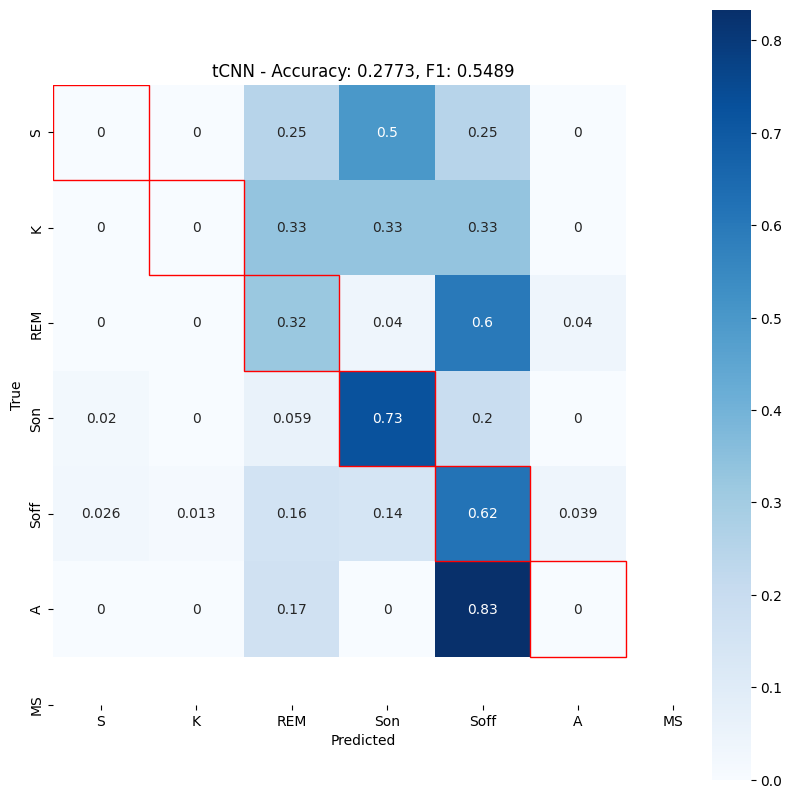

In [55]:
# Calculate class weights based on frequency
def compute_class_weights(y_train):
    class_counts = torch.bincount(y_train)
    total = len(y_train)
    weights = total / (len(class_counts) * class_counts.float())
    return weights


weights = compute_class_weights(_Y_train).to(device)
balanced_model = train_model(model, train_loader, val_loader, num_epochs=30, device=device, lr=1e-4, class_weights=weights)

# load best model
model.load_state_dict(best_model)

# compute metric
Y_pred = model(_X_test.to(device)).argmax(1).cpu().numpy()
score = balanced_accuracy_score(_Y_test, Y_pred)
f1 = f1_score(_Y_test, Y_pred, average='weighted')

# plot confusion matrix
conf_mat = confusion_matrix(_Y_test, Y_pred, normalize='true')
plot_confusion_matrix(conf_mat, markers, f"tCNN - Accuracy: {score:.4f}, F1: {f1:.4f}")


# Conclusions

The models shown here are intended simply as a demonstration for how you can load and process data before fitting and evaluating your own models. There's much more that can be done to improve performance! This is where you come in, experiment with different ideas and come up with a great machine learning model.